# Bayesian Neural Network for touchdown vertical speed prediciton
Author: Yingxiao Kong, Vanderbilt University

Email: kongyingxiao@gmail.com

This module demonstrates how to build a Bayesian Neural Network to predict touchdown vertical speed. 

More information about Bayesian Neural Network can be found [here](https://proceedings.neurips.cc/paper/2016/hash/076a0c97d09cf1a0ec3e19c7f2529f2b-Abstract.html)

## Code Requirements

**DASHlink** data which can be found [here](https://c3.nasa.gov/dashlink/resources/) can be used to extract the flight data.

**Keras** and **Matplotlib** is required to be installed in advance to run this code.  


This code has been tested under python *3.6* and keras *2.3.1*. 

In [25]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout,LSTM,Activation
from keras.optimizers import Adam
from keras.regularizers import l1,l2
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

In [33]:
class BayesianNeuralNetwork():
    '''
    BayesianNeuralNetwork class creates a Bayesian Neural Network to predict touchdown vertical speed 
    with model uncertainty quantified.
      
    
    Methods:
    --------
    get_rnn_model
    get_dnn_model
    custom_model
    bnn_pred
    plot_result
    '''

    def __init__(self):
        self.model = None
        
    def get_rnn_model(self,x_train,y_train, idrop=0.,
                 odrop=0.25,rdrop=0.25,
                 weight_decay=1e-4,lr=1e-3,num_unit=100):
        '''
        Initialize the RNN model.
        
        
        Attributes
        -----------        
        x_train: training data
        y_train: training target  
        idrop: dropout rate for input layer
        odrop: dropout rate for output layer
        rdrop:dropout rate for the recurrent layer(DNN model doesn't need rdrop
              but is provided by default)
        weight_decay: regularization factor
        lr: learning rate
        num_unit: number of unit at each layer
        '''
        
        self.x_train = x_train
        self.y_train = y_train
        self.idrop = idrop
        self.odrop = odrop
        self.rdrop = rdrop
        self.weight_decay = weight_decay
        self.lr = lr
        self.num_unit=num_unit 
        
        
        if len(self.x_train.shape)!=3:
            raise Exception('Expect a 3 dimensional array!')
        in_shape = self.x_train.shape[-1]
        model=Sequential()
        model.add(LSTM(self.num_unit,kernel_regularizer=l2(self.weight_decay),
                       recurrent_regularizer=l2(self.weight_decay),
                       bias_regularizer=l2(self.weight_decay),dropout=self.idrop,
                       recurrent_dropout=self.rdrop,input_shape=(None, in_shape),
                      kernel_initializer='random_uniform',return_sequences=True))

        model.add(Activation('relu'))

        model.add(LSTM(self.num_unit,dropout=self.idrop,
                       recurrent_dropout=self.rdrop,return_sequences=False,
                       kernel_regularizer=l2(self.weight_decay),
                       recurrent_regularizer=l2(self.weight_decay),
                       bias_regularizer=l2(self.weight_decay)))
        model.add(Activation('relu'))
        if self.odrop:
            model.add(Dropout(self.odrop))
        model.add(Dense(1,activation='linear',
                        kernel_regularizer=l2(self.weight_decay),
                        bias_regularizer=l2(self.weight_decay)))
        optimizer_=Adam(self.lr)
        model.compile(loss='mse',metrics=['mse'],optimizer=optimizer_)
        
        self.model = model
    
    def get_dnn_model(self,x_train,y_train, idrop=0.,
                 odrop=0.25,rdrop=0.25,
                 weight_decay=1e-4,lr=1e-3,num_unit=100):
        '''
        Initialize the DNN model.
        
        Attributes
        -----------        
        x_train: training data
        y_train: training target 
        idrop: dropout rate for input layer
        odrop: dropout rate for output layer
        rdrop:dropout rate for the recurrent layer(DNN model doesn't need rdrop
        but is provided by default)
        weight_decay: regularization factor
        lr: learning rate
        num_unit: number of unit at each layer
        '''        
        self.x_train = x_train
        self.y_train = y_train
        self.idrop = idrop
        self.odrop = odrop
        self.rdrop = rdrop
        self.weight_decay = weight_decay
        self.lr = lr
        self.num_unit=num_unit  
        self.model_type = 'DNN'
        

        if len(self.x_train.shape)!=2:
            raise Exception('Expect a 2 dimensional array!')
        in_shape = self.x_train.shape[-1]
        model=Sequential()
        model.add(Dense(self.num_unit,kernel_regularizer=l2(self.weight_decay),
                       bias_regularizer=l2(self.weight_decay),
                        kernel_initializer='random_uniform',
                        input_dim=in_shape))
        
        model.add(Activation('relu'))
        model.add(Dropout(self.idrop))
        model.add(Dense(self.num_unit,kernel_regularizer=l2(self.weight_decay),
                       bias_regularizer=l2(self.weight_decay),
                        kernel_initializer='random_uniform',
                       ))
        model.add(Dropout(self.idrop))
        model.add(Activation('relu'))  
        if self.odrop:
            model.add(Dropout(self.odrop))
        model.add(Dense(1,activation='linear',
                        kernel_regularizer=l2(self.weight_decay),
                        bias_regularizer=l2(self.weight_decay)))
        optimizer_=Adam(self.lr)
        model.compile(loss='mse',metrics=['mse'],optimizer=optimizer_)  
        
        self.model = model
    
    def custom_model(self, model):
        '''
        This method allows you to use your own model, make sure dropout is included in your model, otherwise 
        prediction will be deterministic
        
        '''
        self.model = model
    
    def bnn_pred(self,x_test,uncertainty = 'Y',batch_size=30,epochs=200,iter_=50):
        """
        BDNpred is used to generate results for the deep learning model
        
        Attributes
        ----------
        x_test: test data
        batch_size: mini batch size
        epochs: number of epochs
        iter_: number of predictions for each sample        
        uncertainty: whether to quantity the uncertainty in the model or not;
                    'Y': include uncertainty
                    'N': not include unceratinty
        
        """
        self.x_test = x_test
        self.batch_size = batch_size
        self.epochs = epochs
        self.iter_ = iter_
        self.uncertainty = uncertainty

        if self.model==None:
            raise Exception('A model is needed before calling bnn_pred!if you want to build a RNN model, you should first call get_rnn_model;if you want to build a DNN model, you should first call get_dnn_model;if you want to use your own model, you should first call custom_model.')
        
        #### fit the model        
        self.model.fit(self.x_train,self.y_train,self.batch_size,
                      self.epochs,verbose = False)
        if self.uncertainty =='Y':
            f = K.function([self.model.layers[0].input,
                                K.learning_phase()],[self.model.layers[-1].output])
            results = []
            for i in range(self.iter_):
                results.append(np.squeeze(f([self.x_test,1])))
            results = np.array(results)
        if self.uncertainty == 'N':
            results = self.model.predict(self.x_test)
        return np.transpose(results)
    
    def plot_result(self,true_y, results):
        '''
        This method is used to plot the results with condidence intervals
        
        true_y: the true value of the quantity of interest
        results: the predicted results, the shape should be (n_sample, n_iter) by default
        
        '''
        mean = np.mean(results, axis = 1)
        std = np.mean(results, axis = 1)
        
        sigma_1_lower = mean - std
        sigma_1_upper = mean + std

        sigma_2_lower = mean - 2*std
        sigma_2_upper = mean + 2*std

        sigma_3_lower = mean - 3*std
        sigma_3_upper = mean + 3*std        

        plt.fill_between(np.arange(len(sigma_1_lower)),sigma_1_lower, sigma_1_upper,color = 'blue',alpha = .5,label = '68.3 %')
        plt.fill_between(np.arange(len(sigma_2_lower)),sigma_2_lower, sigma_2_upper,color = 'blue',alpha = .3,label = '95.5 %')
        plt.fill_between(np.arange(len(sigma_3_lower)),sigma_3_lower, sigma_3_upper,color = 'blue',alpha = .1,label = '95.9 %')
        plt.plot(mean,color = 'red',marker = '*',label = 'Predictive mean')
        plt.plot(true_y,color = 'black',marker = '*',label = 'True')
        plt.legend()        

### Example

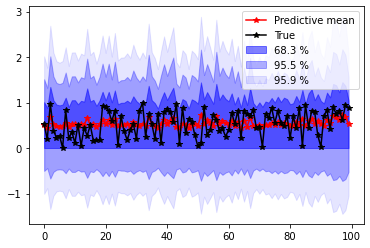

In [32]:
### randomly generate some data for training 

RNN_x_train = RNN_x_test = np.random.rand(100,2,2)
RNN_y_train = RNN_y_test = np.random.rand(100,)

DNN_x_train = DNN_x_test = np.random.rand(100,2)
DNN_y_train = DNN_y_test = np.random.rand(100,)

### Initialize the class

test = BayesianNeuralNetwork()

### Initialize RNN model
test.get_dnn_model(DNN_x_train,DNN_y_train)

### make prediction for test data
predictions = test.bnn_pred(DNN_x_test,uncertainty = 'Y')

### plot the result
test.plot_result(DNN_y_train, predictions)

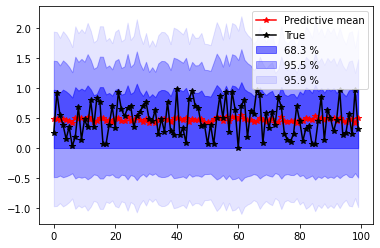

In [34]:
### Initialize RNN model
test.get_rnn_model(RNN_x_train,RNN_y_train)

### make prediction for test data
predictions = test.bnn_pred(RNN_x_test,uncertainty = 'Y')

### plot the result
test.plot_result(RNN_y_train, predictions)